In [1]:
# !pip install --upgrade pandas

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import sem, t
from random import randint


import matplotlib
import matplotlib.pyplot as plt

# Utils

In [3]:
def confidence_interval(X, confidence = 0.95):
    n = len(X)
    m = np.mean(X)
    std_err = sem(X)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return [m-h, m+h]

In [4]:
def mser5y_point(X):
    """ Retorna o ponto de truncagem por meio da Heurística MSER-5Y.
    """
    X = np.array(X)
    
    N = len(X)
    k = N//5
    Z = np.array([
        X[i:i+5].mean() for i in range(k)
    ])
    
    def MSER5Y(k, d):
        """ Valor estatistico MSER-5Y """
        return np.var(X[d:k])/np.sqrt(k-d)
        
    d_points = np.array([
        MSER5Y(k,d) for d in range(k//2)
    ])
    
    return d_points.argmin()

In [85]:
def NBM(X, B=20, M=100, beta=1.29):
    """ Nonoverlapping Batch Means:
        Metodo para tratar correlacao em series temporais
    """
    
    def batched_serie(B, M):
        """ Agrupar as observaçõesem B blocos (batches) de tamanho M. """
        return np.array([
            X[i:i+M].mean() for i in range(0, B*M, M)
        ])
    
    def rvm(serie):
        " Versão Ranking do Teste de von Neuman "
        r = np.array([
            np.sum(x<=serie) for x in serie
        ])
        rvm_value =  (
            np.sum((r[0:-1] - r[1:])**2) / np.sum((r-r.mean())**2)
        )
        return rvm_value
    
    new_X = batched_serie(B, M)
    while B*M<=len(X) and rvm(new_X)<=beta:
        M += 1
        new_X = batched_serie(B, M)
    
    return {
        'B': B,
        'M': M,
        'serie': new_X
    }

# Teste basico com Filas e MSER-5Y

In [6]:
def mm1_simulation(N,lamb,mu,seed=42):
    """ Simulador Simples de fila M/M/1
    """
    np.random.seed(seed)

    # tec: tempo entre chegada
    tec = [np.random.exponential(1/lamb) for _ in range(N)]

    # tdc: tempo de chegada
    tc = [tec[0]]
    for t in tec[1:]:
        tc.append(tc[-1] + t)

    # ta: tempo de atendimetno
    ta = [np.random.exponential(1/mu) for _ in range(N)]

    # tto: tempo total ocioso
    # tte: tempo total de espera
    # t: instante de tempo t
    # y: conjunto de valores de tte
    tto = tc[0]
    tte = 0
    t = tc[0]
    ytotal = [tte]
    yindividual = []
    for i in range(N-1):
        if (t+ta[i]) < tc[i+1]:
            yindividual.append(0)
            tto=tto + tc[i+1]-(t+ta[i])
            t=tc[i+1]
        else:
            yindividual.append((t+ta[i])-tc[i+1])
            tte=tte + yindividual[-1]
            t=t+ta[i]
            
        ytotal.append(tte)

    return {
        'tempo_total': np.array(ytotal),
        'tempo_individual': np.array(yindividual)
    }


def mm1_theoretical_solution(lamb, mu):
    rho = lamb / mu
    return rho / (mu*(1-rho))

λ = 2.5, μ = 10, mser5y_point = 0
λ = 5.0, μ = 10, mser5y_point = 0
λ = 7.5, μ = 10, mser5y_point = 716
λ = 9.0, μ = 10, mser5y_point = 797
λ = 9.5, μ = 10, mser5y_point = 998


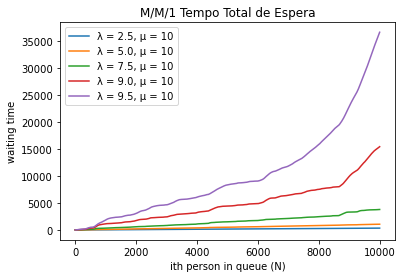

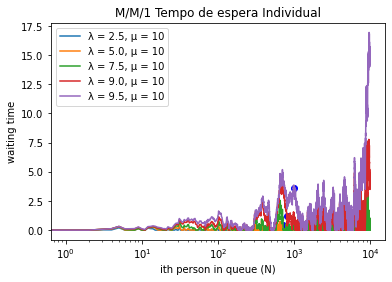

In [17]:
""" experimentos
λ = 2.5, μ = 10
λ = 5.0, μ = 10
λ = 7.5, μ = 10
λ = 9,0, μ = 10
λ = 9.5, μ = 10
"""

lambs = [
    2.5, 
    5.0, 
    7.5, 
    9.0, 
    9.5
] 
mu = 10
N = 10_000

Xt = pd.DataFrame({
    f'λ = {lamb}, μ = {mu}': mm1_simulation(N, lamb, mu)['tempo_total']
    for i, lamb in enumerate(lambs)
})

Xt.plot(
    title  = 'M/M/1 Tempo Total de Espera',
    xlabel = 'ith person in queue (N)',
    ylabel = 'waiting time',
)

X = pd.DataFrame({
    f'λ = {lamb}, μ = {mu}': mm1_simulation(N, lamb, mu)['tempo_individual']
    for i, lamb in enumerate(lambs)
})

ax = X.plot(
    title  = 'M/M/1 Tempo de espera Individual',
    xlabel = 'ith person in queue (N)',
    ylabel = 'waiting time',
    logx = True,
)

pruning_points = X.apply(mser5y_point)
for col, point in pruning_points.items():
    print(f'{col}, mser5y_point = {point}')
    ax.scatter(point, X[col][point], c='blue')

Podemos observar que conforme a intensidade de tráfego (ρ=λ/μ) aumenta o tempo to total de espera na fila tambem aumenta.

Os pontos destacados sao os pontos de truncagem determinados pela Heurística MSER-5Y. 

# M/M/1

## 1) O seguinte experimento deve ser repetido 100 vezes

a) Simular o tempo médio de espera em uma fila M/M/1 e o seu respectivo
intervalo de confiança de 95% ( ).

b) Utilizar o gerador de números aleatórios do Python.

c) Utilizar semente aleatória.

d) Intensidade de tráfego de 25% (λ=2.5 e μ=10.0)

e) Eliminar o transiente utilizando a heurística MSER-5Y.

f) Utilizar o método de análise NBM.

g) A precisão relativa do resultado de cada repetição deve ser menor ou igual a 5%.

## 2) Computar a cobertura do método de análise, isto é, a porcentagem de

intervalos de confiança que contêm o valor teórico conhecido na literatura.

## 3) Plotar um gráfico de linha.

Eixo dos x: número da repetição.

Eixo dos y: tempo médio de espera na fila (plotar também o intervalo de
confiança)
𝑋ത
𝑋ത ∓ 𝐻

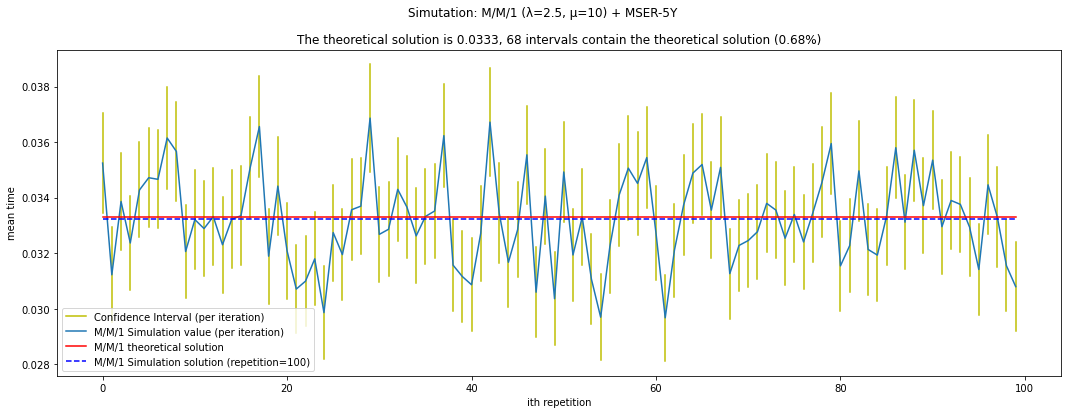

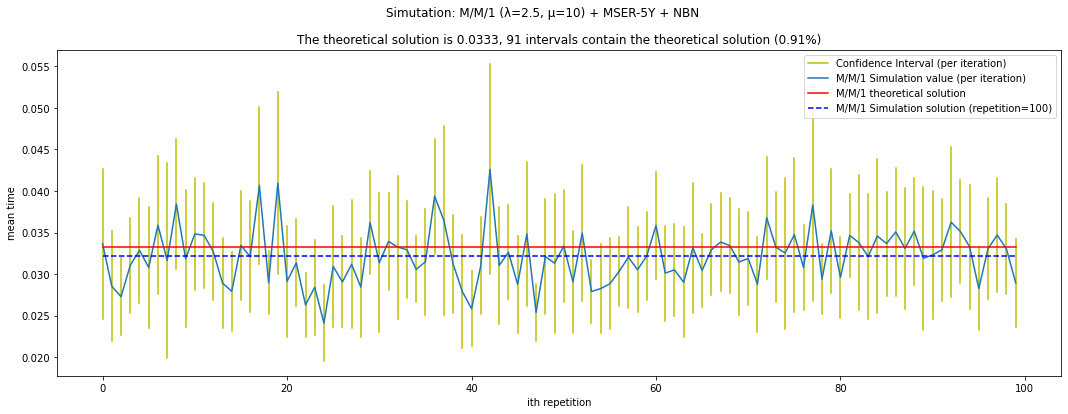

0.91

In [102]:
lamb = 2.5
mu = 10
N = 10_000
repeat = 100





def experiment(lamb, mu, N, repeat):
    solution = np.round(mm1_theoretical_solution(lamb,mu), 4)
    Xmser5y = []
    mser5y_intervals= []
    Xnbm = []
    nbm_intervals = []
    
    def experiment_plot(title, Xserie, confidence_intervals):
        plt.figure(figsize=(18,6))

        solution_count = 0
        for i in range(repeat):
            line, = plt.plot([i,i], confidence_intervals[i], c='y')
            m_minus, m_plus = confidence_intervals[i]
            if m_minus<=solution and solution<=m_plus:
                solution_count += 1

        line.set_label('Confidence Interval (per iteration)')
        line, = plt.plot(range(repeat), Xserie)
        line.set_label('M/M/1 Simulation value (per iteration)')
        line, = plt.plot(range(repeat), [solution]*repeat,c='r')
        line.set_label('M/M/1 theoretical solution')
        line, = plt.plot(range(repeat), [np.mean(Xserie)]*repeat, 'b--')
        line.set_label(f'M/M/1 Simulation solution (repetition={repeat})')

        plt.suptitle(title)
        plt.title(
            f'The theoretical solution is {solution}, {solution_count} intervals contain the theoretical solution ({solution_count/repeat}%)'
        )
        plt.xlabel('ith repetition')
        plt.ylabel('mean time')
        plt.legend()
        plt.show()
        
        return solution_count
        
    # Execute the experiment
    for i in range(repeat):
        data = mm1_simulation(
            N, lamb, mu, 
            seed=randint(1000, 15000)
        )
        
        X = data['tempo_individual']
        X = X[mser5y_point(X):]
        Xmser5y.append(X.mean())
        mser5y_intervals.append(confidence_interval(X))
        
        X = NBM(X)['serie']
        Xnbm.append(X.mean())
        nbm_intervals.append(confidence_interval(X))

        
    # show resoults
    experiment_plot(
        f'Simutation: M/M/1 (λ={lamb}, μ={mu}) + MSER-5Y', 
        Xmser5y, mser5y_intervals
    )
    
    solution_count = experiment_plot(
        f'Simutation: M/M/1 (λ={lamb}, μ={mu}) + MSER-5Y + NBN', 
        Xnbm, nbm_intervals
    )
    
    # return coverage
    nbm_coverage = solution_count/repeat
    return nbm_coverage

    
experiment(lamb, mu, N, repeat)

## 4) Repetir os passos 1-3 para diferentes valores de intensidade de tráfego

a) 50% (λ=5.0 e μ=10.0)

b) 75% (λ=7.5 e μ=10.0)

c) 90% (λ=9.0 e μ=10.0)

d) 95% (λ=9.5 e μ=10.0)

M/M/1 (λ=5.0, μ=10, N=10000, repeat=100)


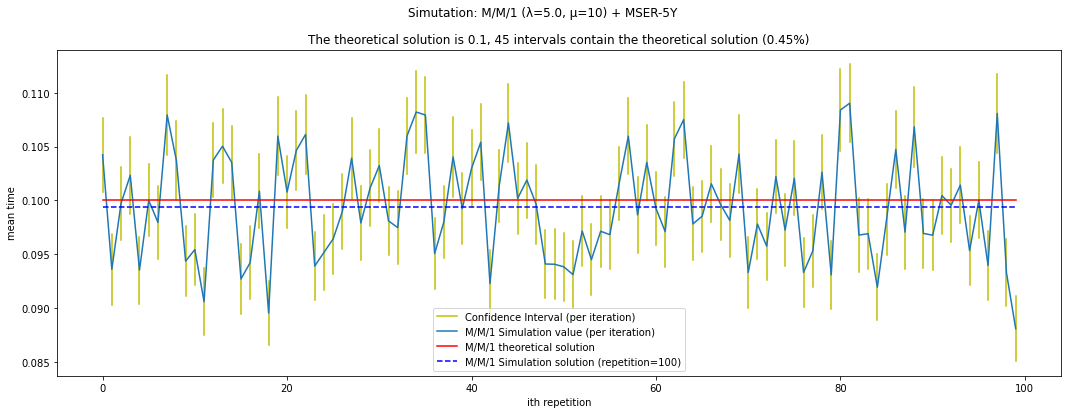

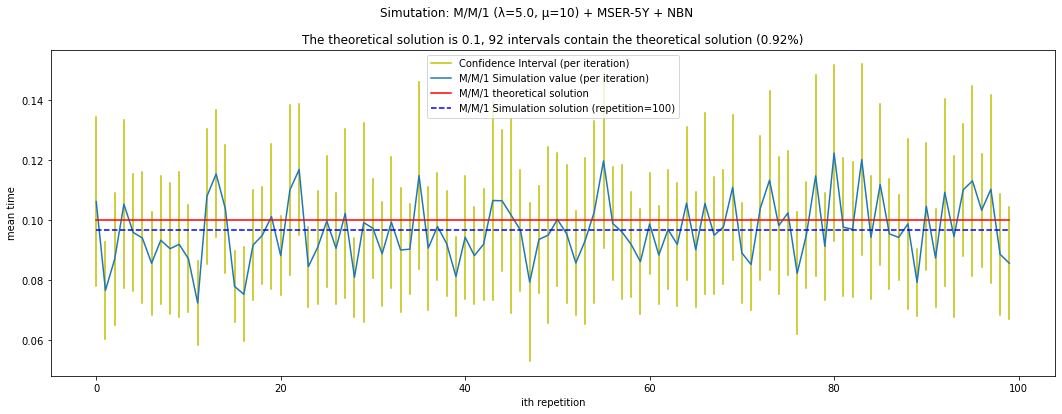


M/M/1 (λ=7.5, μ=10, N=10000, repeat=100)


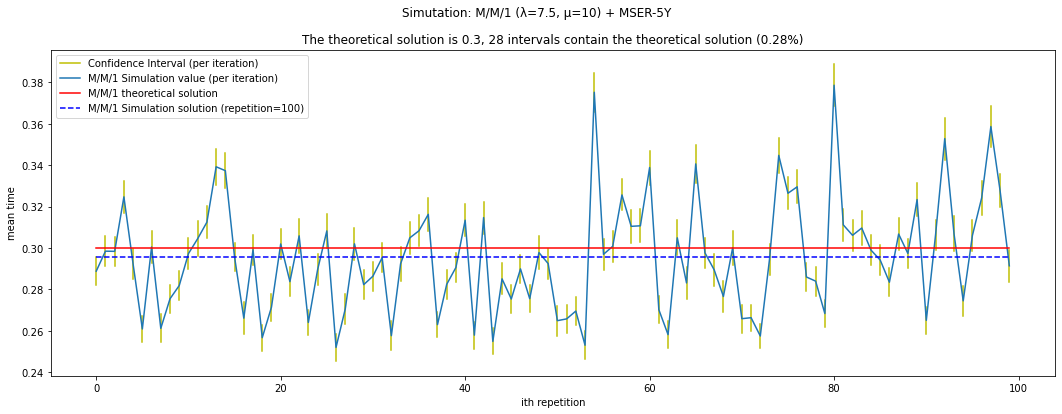

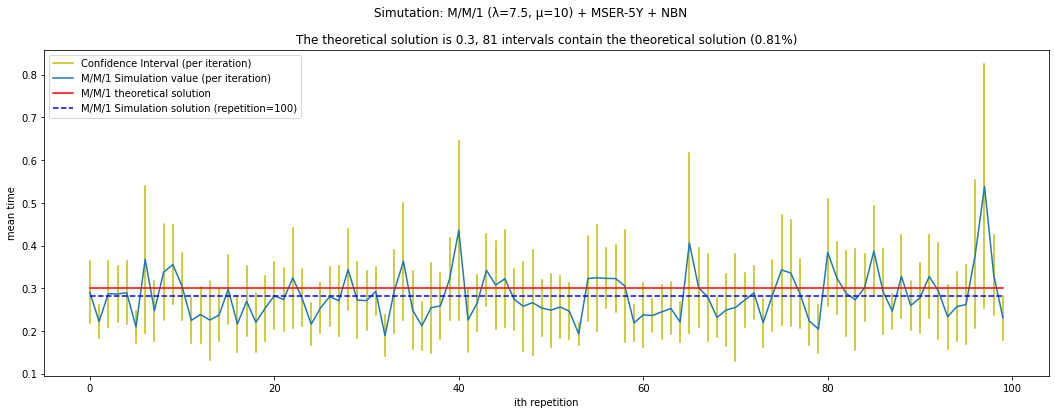


M/M/1 (λ=9.0, μ=10, N=10000, repeat=100)


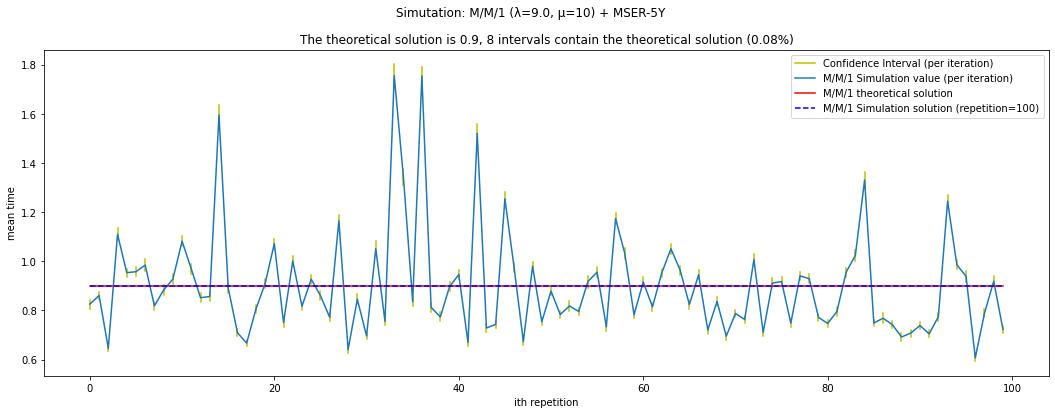

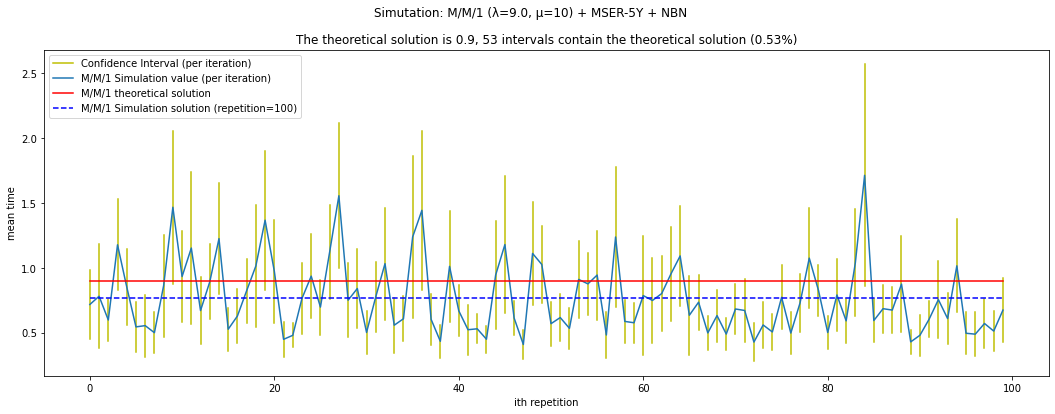


M/M/1 (λ=9.5, μ=10, N=10000, repeat=100)


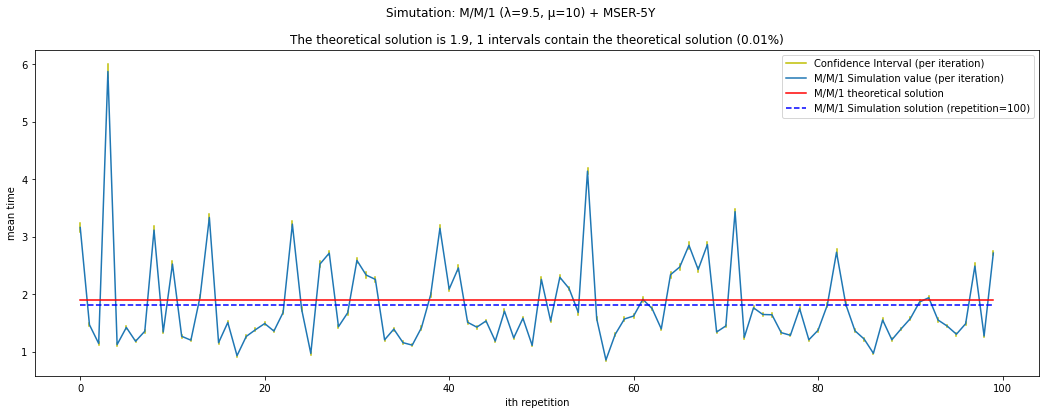

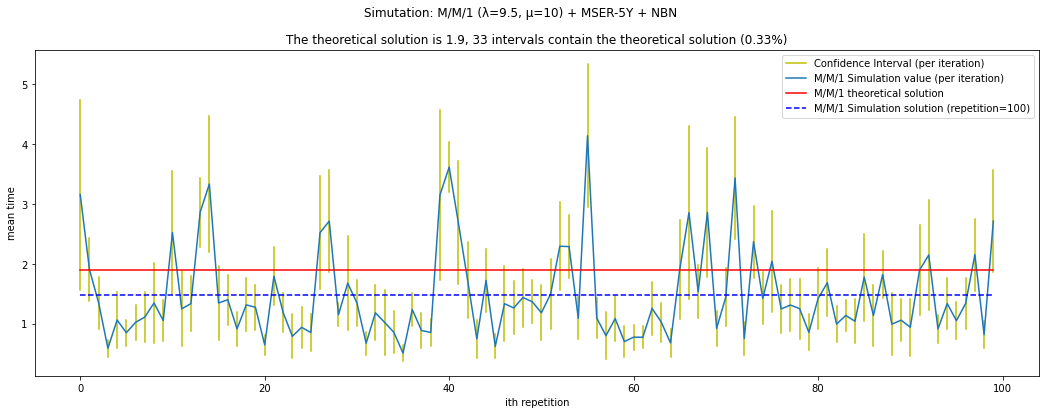

In [118]:
lambs = [
    5.0, 
    7.5, 
    9.0, 
    9.5
] 
mu = 10
N = 10_000
repeat = 100

results = {}
for lamb in lambs:
    experiment_title = f'M/M/1 (λ={lamb}, μ={mu}, N={N}, repeat={repeat})'
    print(experiment_title)
    nbm_coverage = experiment(lamb, mu, N, repeat)
    print()
    results[round(lamb/mu, 3)] = [nbm_coverage]

## 5) Plotar um gráfico de linha.

Eixo dos x: intensidade de tráfego.

Eixo dos y: cobertura dos resultados pelo método NBM

## 6) Faça uma análise da qualidade do método NBM à medida que o sistema simulado

torna-se mais exigido. 

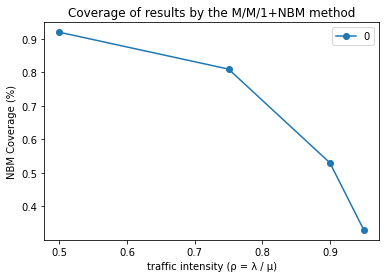

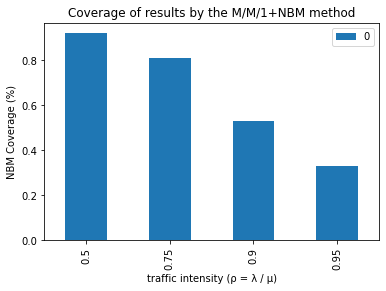

In [141]:
pd.DataFrame(results).T.plot(
    title='Coverage of results by the M/M/1+NBM method',
    xlabel='traffic intensity (ρ = λ / μ)',
    ylabel='NBM Coverage (%)',
    style='-o'
)

pd.DataFrame(results).T.plot.bar(
    title='Coverage of results by the M/M/1+NBM method',
    xlabel='traffic intensity (ρ = λ / μ)',
    ylabel='NBM Coverage (%)',
)